In [1]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import pystan
from criterion import Criterion

import arviz
import pickle

from IPython.display import display


plt.style.use("ggplot")

In [2]:
data = pd.read_csv(Path(os.getcwd(), "input", "data-attendance-2.txt"))

In [3]:
display(data.head())
display(data.describe())

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


,PersonID,A,Score,M,Y
count,50.00000,50.000000,50.000000,50.000000,50.00000
mean,25.50000,0.400000,121.700000,47.920000,34.44000
std,14.57738,0.494872,28.136874,17.953273,12.87643
min,1.00000,0.000000,51.000000,12.000000,10.00000
25%,13.25000,0.000000,105.250000,34.750000,26.00000
50%,25.50000,0.000000,120.500000,48.000000,33.50000
75%,37.75000,1.000000,142.500000,59.000000,43.00000
max,50.00000,1.000000,185.000000,88.000000,63.00000


In [4]:
standata = {"N":len(data), "A":data["A"], "Score":data["Score"]/185, "M":data["Score"], "Y":data["Y"]}

sec5.2と同じデータを用いて、説明変数AとScroreが総授業回数Mにどれだけ影響してるか知りたいとする。

つまり、説明変数がAとScoreで、目的変数がMとみることができる。

授業回数のような、離散値で、今回のパターンだとポアソン分布が使えると言える。

ここでは、ポアソン回帰を見ていく。

説明変数の線形結合$b_1 + b_2 * A + b_3 * Score$をリンク関数を単調増加関数である指数関数で変換しているので説明変数が大きくなれば、Mもそれに従って大きくなるという仮定がある。

なお平均が十分おきければ正規分布で近似できる（収束するのではない）

## model

$$\lambda [n] = exp(b_1 + b_2 A[n] + b_3 Score[n]\tag{1}$$
$$M[n] \sim Poisson(\lambda[n])\tag{2}$$
$$n = 1, \dots , N$$

## complile

In [5]:
# modelを記述した読み込みたいstanファイル
read_stanmodel = "model5-6.stan"
# モデルをセーブしておくpickleファイル
read_file = "model5-6.pkl"

stan_path = Path(os.getcwd(),"model", "stanmodel", read_stanmodel)
pickle_path = Path(os.getcwd(),"model", "model_pkl", read_file)

try:
    with open(pickle_path, "rb") as f:
        print("loading...", pickle_path)
        stanmodel = pickle.load(f)

except FileNotFoundError:
    print("save path to stan file is ", stan_path)
    stanmodel = pystan.StanModel(
        file = str(stan_path),
    )
    with open(pickle_path, "wb") as f:
        pickle.dump(stanmodel, f)
        print("saving finished...")

loading... /Users/chibadaimare/Desktop/Bayes_Stan/stan_with_python/model/model_pkl/model5-6.pkl


In [6]:
%%time

fit = stanmodel.sampling(
    data=standata,
    iter=2000,
    chains=4,
    warmup=200,
    seed=496,

)

CPU times: user 233 ms, sys: 40.8 ms, total: 274 ms
Wall time: 772 ms


In [7]:
print(fit)

Inference for Stan model: anon_model_ea8e88765da25348a45529935f13b133.
4 chains, each with iter=2000; warmup=200; thin=1; 
post-warmup draws per chain=1800, total post-warmup draws=7200.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]         3.76  1.4e-3   0.06   3.64   3.72   3.76   3.81   3.89   2117    1.0
b[2]       6.3e-3  4.5e-4   0.03  -0.05  -0.01 6.5e-3   0.02   0.06   3309    1.0
b[3]         1.53  1.9e-3   0.09   1.36   1.47   1.53   1.59    1.7   2056    1.0
lambda[1]   76.45    0.05   2.48  71.73  74.76  76.36  78.08  81.39   2348    1.0
lambda[2]  144.27    0.05   3.16  138.2 142.09 144.25 146.42 150.51   3867    1.0
lambda[3]  121.48    0.03   2.03 117.45 120.12 121.46 122.83  125.5   5119    1.0
lambda[4]   88.54    0.05   2.42  83.91  86.89  88.53  90.15  93.37   2816    1.0
lambda[5]  160.68    0.07   4.01 152.92 157.92  160.6 163.44 168.55   3294    1.0
lambda[6]   129.8    0.03   2.17 125.56 128.34 129.81 131.24 134.07   5366

得られたパラメータの事後分布のMCMCサンプルの平均から、これらを(1)に代入すると
$$\lambda_{post}[n] = exp(3.76 + 0.0063 A[n] + 1.53 \frac{Score[n]}{185}) \tag{3}$$
$$M[n] \sim Poisson(\lambda_{post}[n])\tag{2}$$

In [8]:
data_rental = pd.read_csv(Path(os.getcwd(), "input", "data-rental.txt"))

In [11]:
display(data_rental.head())
display(data_rental.describe())

,Y,Area
0,263.062,40.66
1,519.000,61.94
2,671.400,55.13
3,473.030,56.82
4,455.600,56.82


,Y,Area
count,100.000000,100.000000
mean,365.532010,36.700500
std,292.191219,18.752761
min,124.600000,11.640000
25%,195.850000,23.062500
50%,261.531000,31.780000
75%,432.550000,45.247500
max,1870.500000,112.820000


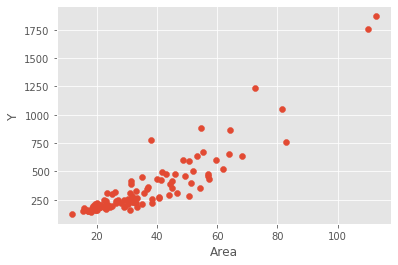

In [9]:
plt.scatter(data_rental["Area"], data_rental["Y"]);
plt.xlabel("Area")
plt.ylabel("Y")
plt.show()

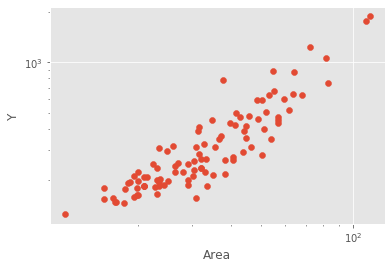

In [10]:
plt.scatter(data_rental["Area"], data_rental["Y"]);
plt.xlabel("Area")
plt.ylabel("Y")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [12]:
# modelを記述した読み込みたいstanファイル
read_stanmodel = "model7-1.stan"
# モデルをセーブしておくpickleファイル
read_file = "model7-1.pkl"

stan_path = Path(os.getcwd(),"model", "stanmodel", read_stanmodel)
pickle_path = Path(os.getcwd(),"model", "model_pkl", read_file)

def read_stanmodel(stan_path, pickle_path):
        
    try:
        with open(pickle_path, "rb") as f:
            print("loading...", pickle_path)
            stanmodel = pickle.load(f)

    except FileNotFoundError:
        print("save path to stan file is ", stan_path)
        stanmodel = pystan.StanModel(
            file = str(stan_path),
        )
        with open(pickle_path, "wb") as f:
            pickle.dump(stanmodel, f)
            print("saving finished...")
    return stanmodel

In [13]:
stanmodel = read_stanmodel(stan_path, pickle_path)

loading... /Users/chibadaimare/Desktop/Bayes_Stan/stan_with_python/model/model_pkl/model7-1.pkl


In [14]:
standata = {
    "N" : len(data_rental),
    "Area" : data_rental["Area"],
    "Y" : data_rental["Y"],
    "sigma" : np.std(data_rental["Y"])
}

In [15]:
standata["sigma"]

290.72659180042325

In [16]:
fit = stanmodel.sampling(
    data=standata,
    iter=2000,
    warmup=200,
    chains=4,
    seed=496,
)

In [17]:
print(fit)

Inference for Stan model: anon_model_67988636c0e384c8ef0ec1d79416d8d6.
4 chains, each with iter=2000; warmup=200; thin=1; 
post-warmup draws per chain=1800, total post-warmup draws=7200.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]        -147.5    1.46  62.91 -268.8 -190.5 -147.9 -105.2 -23.13   1849    1.0
b[2]         13.98    0.04   1.52  11.04  12.95  13.99  15.03  16.95   1846    1.0
mu[1]       421.07    0.35  29.55  360.9 401.34 421.17 440.82 478.68   7277    1.0
mu[2]       718.64    0.84  48.02 623.86 686.16 718.86 750.95 811.96   3273    1.0
mu[3]       623.41    0.63  40.24 543.48 596.09 623.87 650.72 700.55   4065    1.0
mu[4]       647.04    0.68  42.07 563.67 618.47 647.36 675.65 727.92   3816    1.0
mu[5]       647.04    0.68  42.07 563.67 618.47 647.36 675.65 727.92   3816    1.0
mu[6]        69.23    0.94  43.36 -15.34  39.73  69.13  97.83 155.36   2132    1.0
mu[7]       299.97    0.45  29.82 241.46 279.79 300.04 319.95 358

In [18]:
ms = fit.extract()

In [20]:
print(ms)

OrderedDict([('b', array([[ -95.87614758,   13.25084811],
       [-122.44820926,   14.02626924],
       [-291.51857549,   17.00517822],
       ...,
       [-276.03637887,   17.69667615],
       [-118.18163643,   12.37800243],
       [ -51.31913273,   12.45319107]])), ('mu', array([[442.9033366 , 724.88138439, 634.64310876, ..., 695.33199311,
        339.8117383 , 450.05879458],
       [447.85989804, 746.33890746, 650.82001394, ..., 715.06032706,
        338.73552335, 455.43408343],
       [399.91197086, 761.78216335, 645.97689968, ..., 723.86061592,
        267.61168432, 409.0947671 ],
       ...,
       [443.51047319, 820.09574156, 699.58137701, ..., 780.63215375,
        305.83033278, 453.06667831],
       [385.10794223, 648.51183386, 564.21763734, ..., 620.90888845,
        288.80708335, 391.79206354],
       [455.02761617, 720.03152214, 635.22529095, ..., 692.26090605,
        358.14178965, 461.75233935]])), ('y_pred', array([[ 630.64175392,  750.02516678,  556.72099754, ...,  838.

In [19]:
ms.keys()

odict_keys(['b', 'mu', 'y_pred', 'lp__'])

In [21]:
inference_df = pd.DataFrame(data={"Area":data_rental["Area"], "y_pred":np.mean(ms["y_pred"], axis=0)})

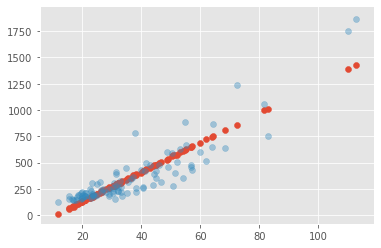

In [22]:
mean = np.mean(ms["y_pred"], axis=0)
plt.scatter(data_rental["Area"], mean)
plt.scatter(data_rental["Area"], data_rental["Y"], alpha=0.4)
plt.show()

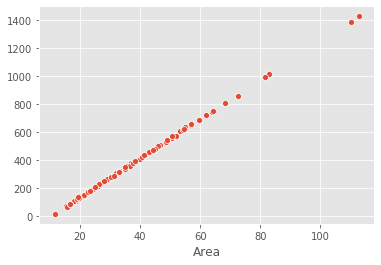

In [24]:
sns.scatterplot(x=data_rental["Area"], y=mean)